In [181]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def de_normalize(pts, H, W, engine='numpy'):
    """
    Args:
        pts: *N x 2 (x, y -> W, H)
    """
    pts_ = pts.copy()
    if engine == 'torch':
        WH = torch.tensor([W, H], dtype=pts.dtype, device=pts.device)
        return (pts + 1) * (WH - 1) / 2.
    pts_[..., 0] = (pts[..., 0] + 1) * (W - 1) / 2.
    pts_[..., 1] = (pts[..., 1] + 1) * (H - 1) / 2.
    return pts_


def normalize(pts, H, W):
    """
    Args:
        pts: *N x 2 (x, y -> W, H)
    """
    pts_ = pts.copy()
    pts_[..., 0] = -1. + 2. * pts[..., 0] / (W - 1)
    pts_[..., 1] = -1. + 2. * pts[..., 1] / (H - 1)
    return pts_

def pix2coord(x, downsample=4):
    """convert pixels indices to real coordinates for 3D 2D projection
    """
    return x * downsample + downsample / 2.0 - 0.5

def coord2pix(y, downsample=4):
    """convert real coordinates to pixels indices for 3D 2D projection
    """
    # x * downsample + downsample / 2.0 - 0.5 = y
    return (y + 0.5 - downsample / 2.0) / downsample

def BGR2Lab(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

def Lab2ab(image):
    _, A, B = cv2.split(image)
    return np.stack([A, B])

def de_transform(img):
    img[..., 0, :, :] = img[..., 0, :, :] * 0.229 + 0.485
    img[..., 1, :, :] = img[..., 1, :, :] * 0.224 + 0.456
    img[..., 2, :, :] = img[..., 2, :, :] * 0.225 + 0.406
    return img


dict_keys(['img1', 'img2', 'img1_path', 'img2_path', 'heatmap', 'other_heatmap', 'points-2d', 'corr_pos_pred', 'depth', 'heatmap_pred', 'batch_locs', 'camera', 'other_camera', 'sample_locs'])
1.0
0.0
(256, 256, 3)
(256, 256, 2)
0 2
(64, 64, 64)


<IPython.core.display.Javascript object>


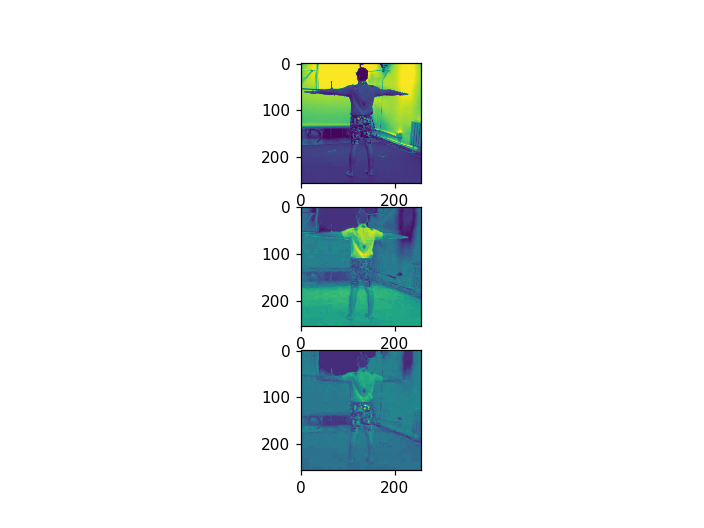

In [182]:

import pickle
with open("../outs/epipolar/keypoint_h36m_fixed_aug/visualizations/h36m/output_0.pkl","rb") as f:
    output = pickle.load(f)
print(output.keys())
img1 = output['img1'][0]
img1 = de_transform(img1).transpose(1,2,0)
print(img1[:, :, 0].max())
print(img1[:, :, 0].min())
img2 = output['img2'][0]
img2 = de_transform(img2).transpose(1,2,0)
img1_lab = BGR2Lab(img1)
img1_ab = Lab2ab(BGR2Lab(img1)).transpose(1,2,0)
img2_ab = Lab2ab(BGR2Lab(img2)).transpose(1,2,0)
print(img1_lab.shape)
print(img2_ab.shape)

img1 = img1[:, :, ::-1]
img2 = img2[:, :, ::-1]

depth = output['depth']
corr_pos_pred = output['corr_pos_pred']
sample_locs = output['sample_locs']
img1_path = output['img1_path']
img2_path = output['img2_path']
camera = output['camera'][0]
other_camera = output['other_camera'][0]
print(camera, other_camera)

heatmap_pred = output['heatmap_pred']
batch_locs = output['batch_locs']
points_2d = output['points-2d']

# print(batch_locs)
# print(points2d[camera])

# for i in range(17):
#     print(batch_locs[i][0], batch_locs[i][1])
#     print(points_2d[camera][i][0], points_2d[camera][i][1])
    
print(depth.shape)
fig, ax = plt.subplots(3)
ax[0].imshow(img1_lab[:, :, 0])
ax[1].imshow(img1_lab[:, :, 1])
ax[2].imshow(img1_lab[:, :, 2])
plt.show()

In [183]:
import scipy
from matplotlib.patches import Circle

In [184]:
ref_img = img1

print(sample_locs.shape)

H, W = ref_img.shape[:2]
print(H, W)
print(img1_path)
print(img2_path)

(64, 64, 64, 2)
256 256
datasets/h36m/images.zip@/images/s_09_act_02_subact_01_ca_01/s_09_act_02_subact_01_ca_01_000001.jpg
datasets/h36m/images.zip@/images/s_09_act_02_subact_01_ca_03/s_09_act_02_subact_01_ca_03_000001.jpg


<IPython.core.display.Javascript object>


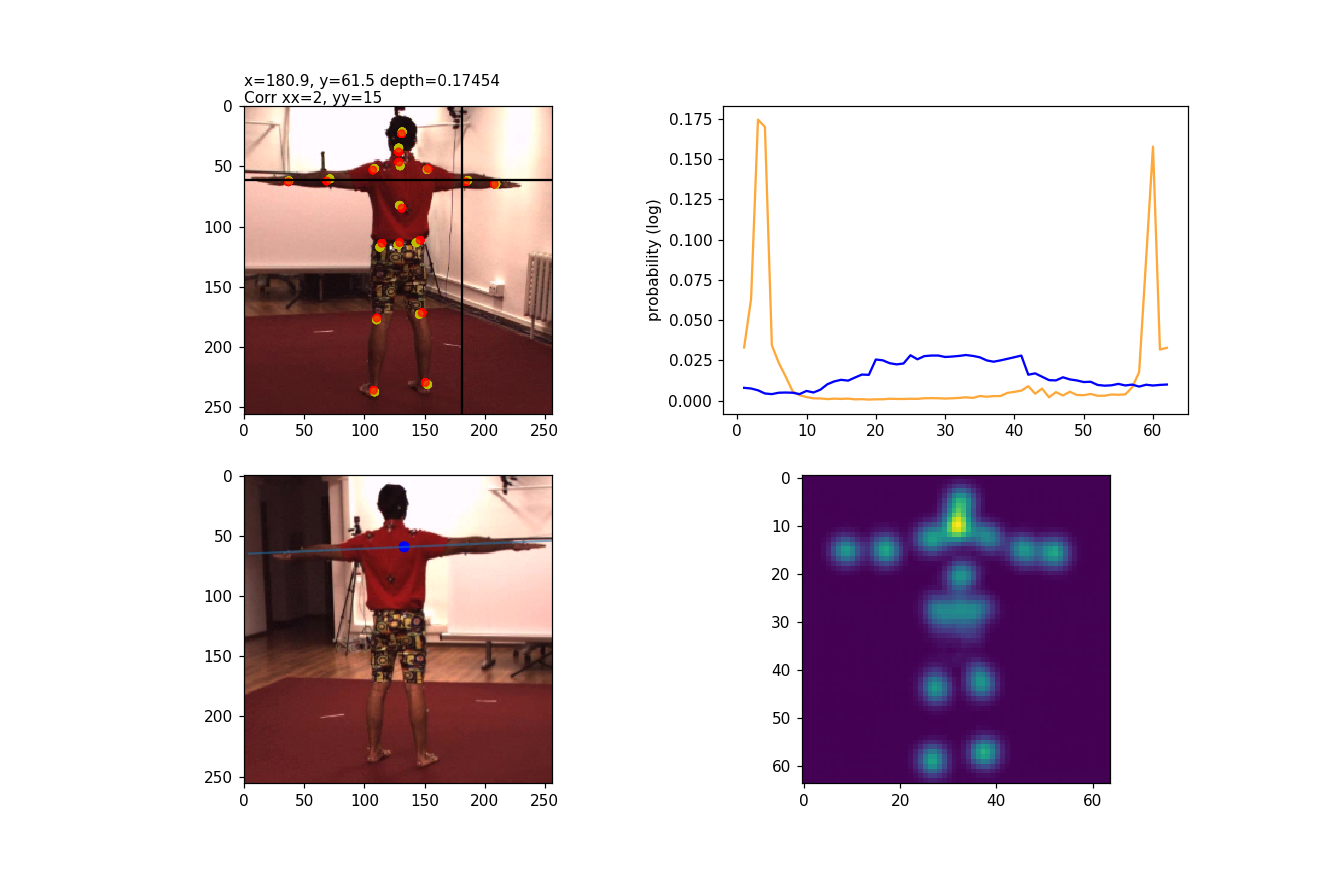

7

In [185]:
%matplotlib notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines

# sample the probability cost-volume
""" Data
"""
class Cursor(object):
    def __init__(self, sample_ax, draw_ax):
        self.sample_ax = sample_ax
        self.draw_ax = draw_ax
        self.lx = sample_ax.axhline(color='k')  # the horiz line
        self.ly = sample_ax.axvline(color='k')  # the vert line

        # text location in axes coords
        self.txt = sample_ax.text(0, 0, '', va="bottom", ha="left")

    def mouse_down(self, event):
        global ref_img, depth, corr_pos_pred, H, W
        if not event.inaxes:
            return

        x, y = event.xdata, event.ydata
        cx, cy = coord2pix(x), coord2pix(y)
        
        pr_cost_volume = depth[:, int(cy), int(cx)]
        cost_volume_xs = np.arange(0, pr_cost_volume.shape[0])

            
        # update the line positions
        self.lx.set_ydata(y)
        self.ly.set_xdata(x)
        
        xx, yy = corr_pos_pred[int(cy)][int(cx)]
        
        
        for i in range(17):
            circ = Circle((points_2d[camera][i][0], points_2d[camera][i][1]), 3, color='y', alpha=0.5)
            self.sample_ax.add_patch(circ)
            
        for i in range(17):
            circ = Circle((batch_locs[i][0], batch_locs[i][1]), 3, color='r', alpha=0.5)
            self.sample_ax.add_patch(circ)
            
        self.txt.set_text('x=%1.1f, y=%1.1f depth=%.5f\nCorr xx=%d, yy=%d' % (x, y, np.max(pr_cost_volume), xx, yy))
        self.sample_ax.figure.canvas.draw()
        
        ################
    
        self.draw_ax.clear()
        self.draw_ax.plot(cost_volume_xs[1:-1], pr_cost_volume[1:-1], color='#fea83a', label='feature matching')
#         self.draw_ax.set_yscale('log')
        self.draw_ax.set_ylabel('probability (log)')
        
        
        # draw color matching
        ref_point = img1_ab[int(y), int(x), :]
        color_score = []
        max_score_id = None
        max_score = -1
        
        for i in range(0, 64):
            pos = sample_locs[i][int(cy)][int(cx)]
            depos = de_normalize(pos, H, W)
            source_point = img2_ab[int(depos[1]), int(depos[0]), :]
            color_score.append(np.dot(ref_point, source_point))
            if color_score[-1] > max_score:
                max_score = color_score[-1]
                max_score_id = (int(depos[0]), int(depos[1]))
                
        color_score = color_score / sum(color_score)
        
        self.draw_ax.plot(cost_volume_xs[1:-1], color_score[1:-1], color='b', label='rgb matching')
        self.draw_ax.figure.canvas.draw()
        
        ########################
        axs[1, 0].clear()
        axs[1, 0].imshow(img2)
        
        circ = Circle(max_score_id, 4, color='b')
        axs[1, 0].add_patch(circ)
        
        # draw epipolar lines
        line_start1 = de_normalize(sample_locs[1][int(cy)][int(cx)], H, W)
        line_start2 = de_normalize(sample_locs[63][int(cy)][int(cx)], H, W)
        axs[1, 0].plot([line_start1[0], line_start2[0]], [line_start1[1], line_start2[1]], alpha=0.5)
        p10 = axs[1, 0].text(0, 0, '', va="bottom", ha="left")
        p10.set_text('max_score_id: %1.1f, %1.1f, colormax=%1.1f'%(max_score[0], max_score[1], max(color_score)))
        
        circ = Circle((pix2coord(xx), pix2coord(yy)),4,color='r')
        axs[1, 0].add_patch(circ)
        

        for i in range(17):
            circ = Circle((points_2d[other_camera][i][0], points_2d[other_camera][i][1]), 3, color='y', alpha=0.5)
            axs[1, 0].add_patch(circ)

        
fig, axs = plt.subplots(2, 2,  squeeze=True, figsize=(12, 8))
cus = Cursor(axs[0,0], axs[0,1])
axs[0,0].imshow(ref_img)

# max_score = np.log(np.max(depth, axis=0))
# print(max_score.shape)
# print(max_score)
# max_score = (max_score - max_score.min())
# max_score = max_score / max_score.max()
prob_im = axs[1, 1].imshow(heatmap_pred.sum(0))

fig.canvas.mpl_connect('button_press_event', cus.mouse_down)

In [186]:
x = 113
y = 22.9
cx, cy = coord2pix(x), coord2pix(y)

ref_point = img1_ab[int(y), int(x), :]
color_score = []
max_score_id = None
max_score = -1
print(ref_point)
print(source_point)

for i in range(0, 64):
    pos = sample_locs[i][int(cy)][int(cx)]
    depos = de_normalize(pos, H, W)
    source_point = img2_ab[int(depos[1]), int(depos[0]), :]
    color_score.append(np.dot(ref_point, source_point))
    if color_score[-1] > max_score:
        max_score = color_score[-1]
        max_score_id = (int(depos[0]), int(depos[1]))

color_score = color_score / sum(color_score)

[ 1.765625 -1.25    ]
[13.640625 14.25    ]
